In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
from chnet.ch_loader import CahnHillDataset

In [4]:
warnings.filterwarnings('ignore')

In [5]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [6]:
def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.01, 0.3, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.98, 0.98, out=x_data)
    
    return x_data

## Loss Functions

In [7]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Transformers

In [8]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

## Data Generators

In [43]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   n_step = 5,
                   device = torch.device("cuda:0")):
    
    init_data = init_norm(nsamples, dim_x, dim_x, seed=seed)   

    x_list = []
    y_list = []
    
    x_list.append(init_data[None])
    x_data = init_data.copy()
    
    for _ in range(n_step):
        x_data = ch.ch_run_torch(x_data, 
                                 dt=dt, gamma=gamma, 
                                 dx=dx, sim_step=init_steps, 
                                 device=device)
        y_list.append(x_data[None])
    
    x_data = np.moveaxis(np.concatenate(x_list, axis=0), 0, 1)
    y_data = np.moveaxis(np.concatenate(y_list, axis=0), 0, 1)
    
    return x_data, y_data

In [55]:
%%time
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=1, 
                                delta_sim_steps = 100,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = 23846,
                                n_step=20,
                                device = torch.device("cuda:0"))

CPU times: user 24.8 ms, sys: 6.34 ms, total: 31.1 ms
Wall time: 30.7 ms


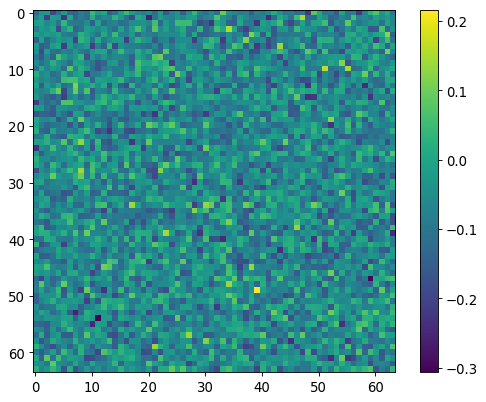

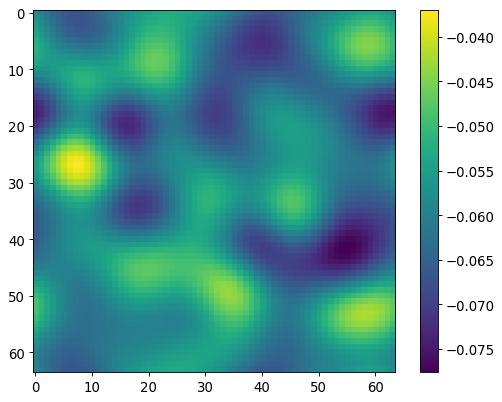

In [59]:
draw_im(x_data[0][0])
draw_im(y_data[0][-1])

# Set Device

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [61]:
from lstm_unet.lstm_mmunet2 import LSTM_MMUnet

In [63]:
model = LSTM_MMUnet(input_nc=1, output_nc=1, ngf=32, temporal=4).to(device)
out_un, out_ls = model(torch.rand(1,1,32,32).to(device))

In [20]:
# summary(model, input_size=(1,32, 32))

In [65]:
transformer_x = lambda x: x[:,None]
transformer_y = lambda x: x[:,None]
# from pymks.bases import LegendreBasis
# n_states = 3
# domain = (-1.01, 1.01)
# basis = LegendreBasis(n_states, domain)
# transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
# transformer_y = lambda x: x[None]



dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 1, 64, 64]) torch.Size([1, 20, 1, 64, 64])


In [70]:
item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

model = LSTM_MMUnet(input_nc=1, output_nc=1, ngf=16, temporal=20).double().to(device)
y_pred, _ = model(x[:,0])

print(y_pred.shape)

assert y.shape == y_pred.shape
# print(mse_loss(y, y_pred).data)

torch.Size([1, 20, 1, 64, 64])


# Model Training

### Training and Validation data generation

In [72]:
## Process Parameters
dim_x=64
init_steps=1
delta_sim_steps = 100
dx = 0.25 
dt = 0.01
gamma=1.0
n_step = 10


seed_trn = 237452 #110364
seed_val = 986423
seed_prd = 284296


trn_size = 2
n_samples_trn = 1024*trn_size
n_samples_val = 256
n_samples_prd = 256

init_features=32

args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [74]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =seed_trn,
                              n_step=n_step,
                              device = device)

CPU times: user 853 ms, sys: 845 ms, total: 1.7 s
Wall time: 949 ms


In [77]:
%%time
x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                n_step = 20,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma,
                                n_step = 20,
                                seed =seed_prd,
                                device = device)

CPU times: user 491 ms, sys: 931 ms, total: 1.42 s
Wall time: 391 ms


In [78]:
# from pymks.bases import LegendreBasis

# n_states = 7
# domain = (-1.01, 1.01)
# basis = LegendreBasis(n_states, domain)
# transformer_x = lambda x: np.moveaxis(basis.discretize(x), 2, 0)
# transformer_x = lambda x: x
# transformer_y = lambda x: x[None]

transformer_x = lambda x: x[:,None]
transformer_y = lambda x: x[:,None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 8

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 256
No. of validation steps: 32
No. of prediction steps: 32


In [79]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")
# dt_string = "dummy"

In [80]:
run_id = dt_string + "_run_base_{}_data_{}_UNet2D".format(1, trn_size)
print(run_id)

folder = "out/new_unet_lstm_trial/ch_unet_id_{}/".format(run_id)
print(folder)


tag = folder+"unet_"
print(tag)

28-06-2020-00-09_run_base_1_data_2_UNet2D
out/new_unet_lstm_trial/ch_unet_id_28-06-2020-00-09_run_base_1_data_2_UNet2D/
out/new_unet_lstm_trial/ch_unet_id_28-06-2020-00-09_run_base_1_data_2_UNet2D/unet_


In [81]:
if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)

In [82]:
criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [83]:
n_params = 0
for params in model.parameters():
    n_params += np.prod(params.shape)
#     print(np.prod(params.shape))
print(n_params)

2188594


In [88]:
from lstm_unet.lstm_mmunet2 import LSTM_MMUnet
model = LSTM_MMUnet(input_nc=1, output_nc=1, ngf=32, temporal=n_step).double().to(device)

In [89]:
num_epochs = 5
# Loss and optimizer
for epoch in range(num_epochs):               
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):     
        model.train()

        x = item_trn['x'].to(device)
        y_t = item_trn['y'].to(device)

        # Forward pass
        y_u, y_p = model(x[:,0])
        loss = criterion(y_t, y_u) + criterion(y_t, y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 128 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2_u, y2_p = model(x1[:,0])
                val_losses.append(np.sqrt(criterion(y2_u, y1).item())+np.sqrt(criterion(y2_p, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))

Epoch [1/5], Step [1/256], Training Loss: 30.43198118689, Validation Loss: 16.15225223804
Epoch [1/5], Step [129/256], Training Loss: 24.17714874914, Validation Loss: 41.73762611293



Epoch [2/5], Step [1/256], Training Loss: 24.11577812492, Validation Loss: 44.61888877588
Epoch [2/5], Step [129/256], Training Loss: 24.34637659870, Validation Loss: 41.67401807002



Epoch [3/5], Step [1/256], Training Loss: 24.06634797065, Validation Loss: 40.69678169744
Epoch [3/5], Step [129/256], Training Loss: 24.30623326272, Validation Loss: 43.19044302347



Epoch [4/5], Step [1/256], Training Loss: 24.19410765519, Validation Loss: 46.25791397650
Epoch [4/5], Step [129/256], Training Loss: 23.92947615005, Validation Loss: 40.69511778676



Epoch [5/5], Step [1/256], Training Loss: 24.13608377717, Validation Loss: 43.55005588344
Epoch [5/5], Step [129/256], Training Loss: 24.32325097455, Validation Loss: 42.43092014223



In [90]:
x_trn, y_trn = data_generator(nsamples=1024*5, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed=92836498,
                                device = device)

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
batch_size = 8
trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

num_epochs = 5

# Loss and optimizer
for epoch in range(num_epochs):                 
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_t = item_trn['y'].to(device)

        # Forward pass
        y_p = model(x)
        loss = criterion(y_t, y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 128 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            

No. of training steps: 640
No. of validation steps: 32
No. of prediction steps: 32


Epoch [1/5], Step [1/640], Training Loss: 9.20604875939, Validation Loss: 15.63779130728
Epoch [1/5], Step [129/640], Training Loss: 9.19756400109, Validation Loss: 16.11258749740
Epoch [1/5], Step [257/640], Training Loss: 9.36562324079, Validation Loss: 15.51012951847
Epoch [1/5], Step [385/640], Training Loss: 8.94392485436, Validation Loss: 14.88369968695
Epoch [1/5], Step [513/640], Training Loss: 9.19409651794, Validation Loss: 14.56443532536



Epoch [2/5], Step [1/640], Training Loss: 8.96975334367, Validation Loss: 16.33890763800
Epoch [2/5], Step [129/640], Training Loss: 8.80961489339, Validation Loss: 15.38539061418
Epoch [2/5], Step [257/640], Training Loss: 8.40778419665, Validation Loss: 14.48860760479
Epoch [2/5], Step [385/640], Training Loss: 8.35312794581, Validation Loss: 14.71372887944
Epoch [2/5], Step [513/640], Training Loss: 8.34446546276, Validation Loss: 15.02518351305



Epoch [3/5], Step [1/640], Training Loss: 8.39688150490, Validation Loss: 14.62486826935
Epoch [3/5], Step [129/640], Training Loss: 8.23648152344, Validation Loss: 15.09833326304
Epoch [3/5], Step [257/640], Training Loss: 8.02647546524, Validation Loss: 13.77113881105
Epoch [3/5], Step [385/640], Training Loss: 7.91606015481, Validation Loss: 13.95544367353
Epoch [3/5], Step [513/640], Training Loss: 7.93393962226, Validation Loss: 14.78530138441



Epoch [4/5], Step [1/640], Training Loss: 7.84815476701, Validation Loss: 14.83218759914
Epoch [4/5], Step [129/640], Training Loss: 7.68394005795, Validation Loss: 13.67152263845
Epoch [4/5], Step [257/640], Training Loss: 7.71053359800, Validation Loss: 14.36068381207
Epoch [4/5], Step [385/640], Training Loss: 7.57374214971, Validation Loss: 15.09628120716
Epoch [4/5], Step [513/640], Training Loss: 7.46895251699, Validation Loss: 15.01067129509



Epoch [5/5], Step [1/640], Training Loss: 7.49821458533, Validation Loss: 14.12951591101
Epoch [5/5], Step [129/640], Training Loss: 7.41707889573, Validation Loss: 13.98263233526
Epoch [5/5], Step [257/640], Training Loss: 7.27122232322, Validation Loss: 14.22167734281
Epoch [5/5], Step [385/640], Training Loss: 7.30014141278, Validation Loss: 14.38820272244
Epoch [5/5], Step [513/640], Training Loss: 7.31294091080, Validation Loss: 14.28956092141



In [92]:
%%time
x_trn, y_trn = data_generator(nsamples=1024*5, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed=71079*53,
                                device = device)




trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
batch_size = 8
trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)



total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)


num_epochs = 5
# Loss and optimizer
for epoch in range(num_epochs):    
#     torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_t = item_trn['y'].to(device)

        # Forward pass
        y_p = model(x)
        loss = criterion(y_t, y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 512 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))


            
x_trn, y_trn = data_generator(nsamples=1024*5, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed=1079*93,
                                device = device)




trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
batch_size = 8
trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)



total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)


num_epochs = 5
# Loss and optimizer
for epoch in range(num_epochs):    
#     torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_t = item_trn['y'].to(device)

        # Forward pass
        y_p = model(x)
        loss = criterion(y_t, y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 512 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))

No. of training steps: 640
No. of validation steps: 32
No. of prediction steps: 32


Epoch [1/5], Step [1/640], Training Loss: 7.27536024963, Validation Loss: 14.06508468701
Epoch [1/5], Step [513/640], Training Loss: 6.84738242862, Validation Loss: 14.30255478874



Epoch [2/5], Step [1/640], Training Loss: 7.00096115292, Validation Loss: 14.53775246407
Epoch [2/5], Step [513/640], Training Loss: 6.74089397880, Validation Loss: 14.63065233717



Epoch [3/5], Step [1/640], Training Loss: 6.90482523970, Validation Loss: 14.57378553866
Epoch [3/5], Step [513/640], Training Loss: 6.65306117482, Validation Loss: 14.07707306732



Epoch [4/5], Step [1/640], Training Loss: 6.49896705986, Validation Loss: 13.95847385713
Epoch [4/5], Step [513/640], Training Loss: 6.30122369716, Validation Loss: 14.55608085337



Epoch [5/5], Step [1/640], Training Loss: 6.62609007043, Validation Loss: 13.43288321061
Epoch [5/5], Step [513/640], Training Loss: 6.20866076667, Validation Loss: 14.30883434164

No. of training steps: 640
No. of validation steps: 32
No. of prediction steps: 32


Epoch [1/5], Step [1/640], Training Loss: 6.23945446709, Validation Loss: 14.65613664708
Epoch [1/5], Step [513/640], Training Loss: 6.22944602707, Validation Loss: 14.31791962863



Epoch [2/5], Step [1/640], Training Loss: 6.22057984761, Validation Loss: 13.69694598134
Epoch [2/5], Step [513/640], Training Loss: 6.08430648165, Validation Loss: 14.32390444027



Epoch [3/5], Step [1/640], Training Loss: 5.69642177437, Validation Loss: 13.79741166017
Epoch [3/5], Step [513/640], Training Loss: 6.05422401147, Validation Loss: 14.27401492969



Epoch [4/5], Step [1/640], Training Loss: 5.83742509968, Validation Loss: 13.84509234678
Epoch [4/5], Step [513/640], Training Loss: 5.59971490902, Validation Loss: 14.79988282611



Epoch [5/5], Step [1/640], Training Loss: 5.57408354526, Validation Loss: 14.28226536500
Epoch [5/5], Step [513/640], Training Loss: 5.56465853785, Validation Loss: 14.23886983713

CPU times: user 16min 25s, sys: 10min 46s, total: 27min 12s
Wall time: 27min 13s


In [67]:
# prd_losses = []
# for item_prd in trn_loader:
#     model.eval()
#     x1 = item_prd['x'].to(device)
#     y1 = item_prd['y'].to(device)
#     # Forward pass
#     y2 = model(x1)
#     prd_losses.append(np.sqrt(criterion(y2, y1).item()))
# print(np.mean(prd_losses), np.std(prd_losses))

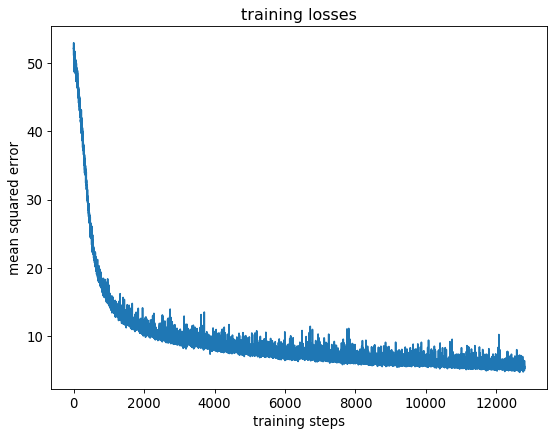

In [93]:
plt.plot(trn_losses)
# plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
# plt.legend(["trn", "val"])
plt.show()

In [94]:
err = []
for ix, item_prd in enumerate(prd_dataset):
    x1 = item_prd['x'][None].to(device)
    y1 = item_prd['y'][None].to(device)
    y2 = model(x1)
    err.append(np.sqrt(mse_loss(y1.detach().cpu(), y2.detach().cpu())))
    
print("Mean Error on Validation Set: {:1.4f}".format(np.mean(err)))

Mean Error on Validation Set: 0.1157


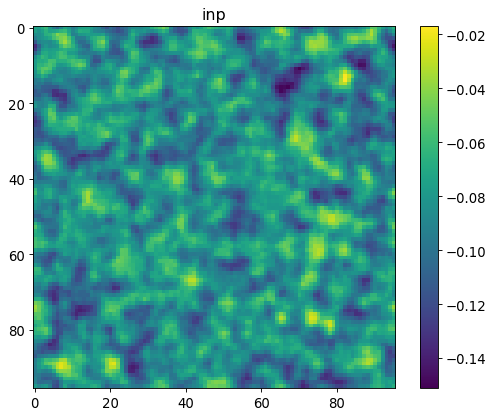

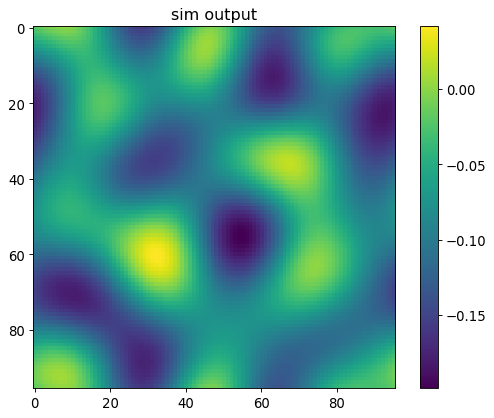

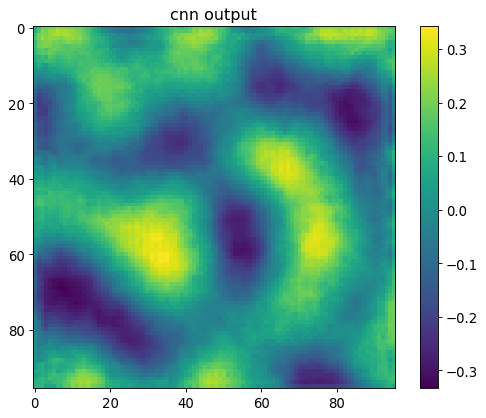

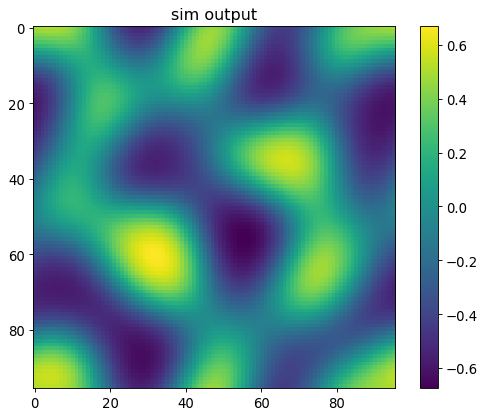

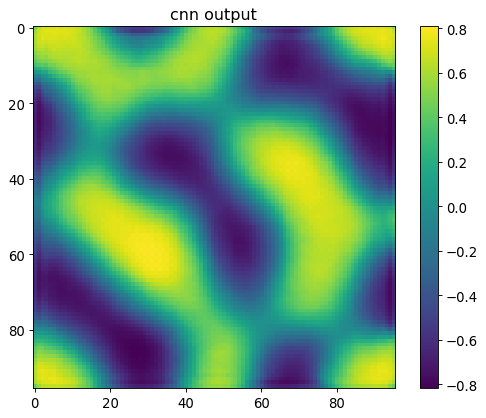

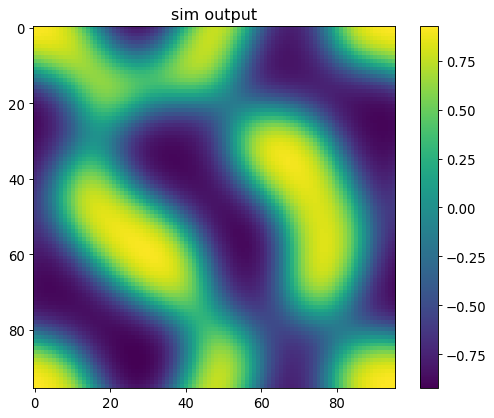

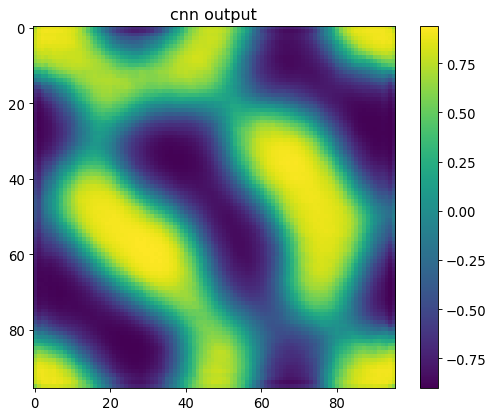

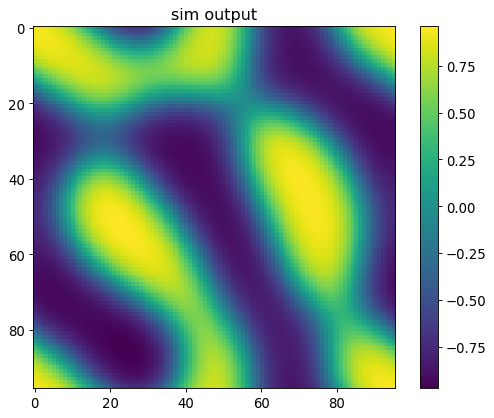

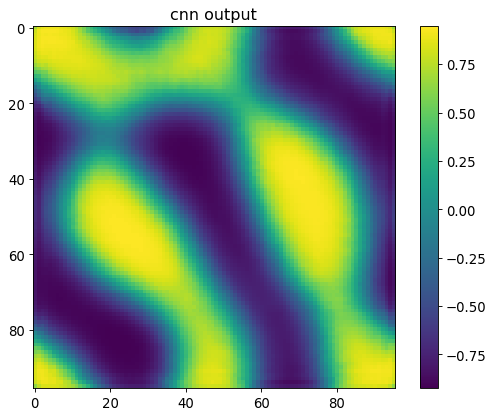

In [96]:
ix = 15

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[0], "inp")

draw_im(im_y1[0], "sim output")
draw_im(im_y2[0], "cnn output")

draw_im(im_y1[1], "sim output")
draw_im(im_y2[1], "cnn output")

draw_im(im_y1[2], "sim output")
draw_im(im_y2[2], "cnn output")

draw_im(im_y1[3], "sim output")
draw_im(im_y2[3], "cnn output")

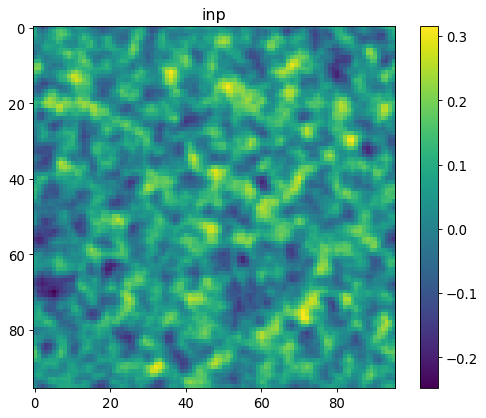

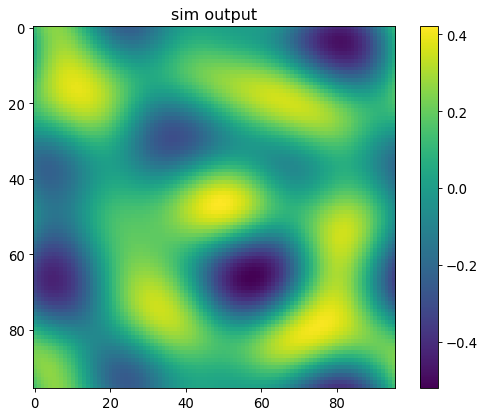

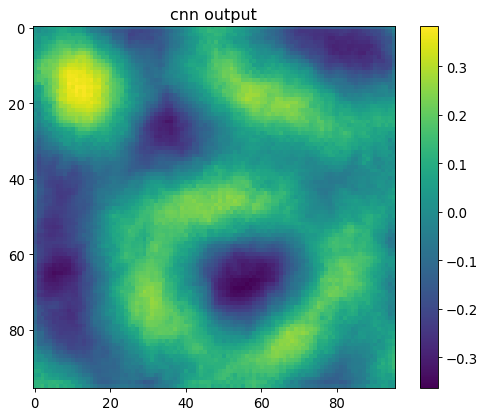

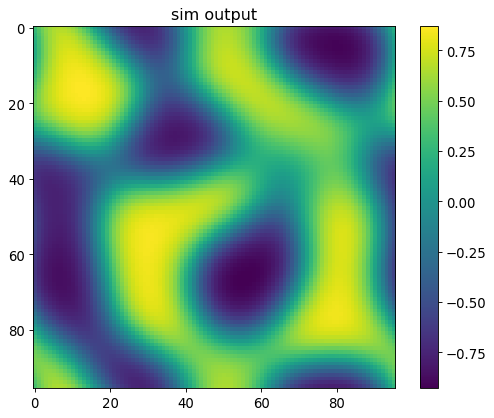

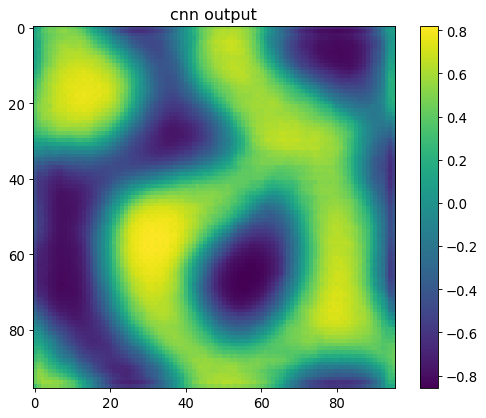

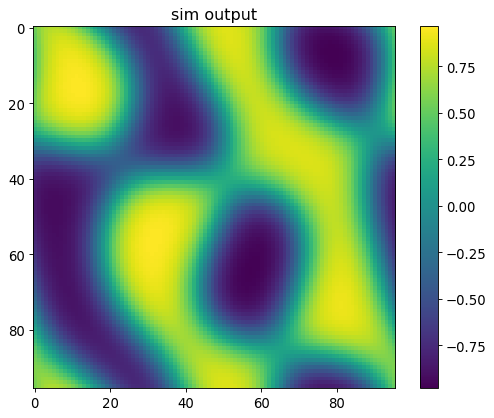

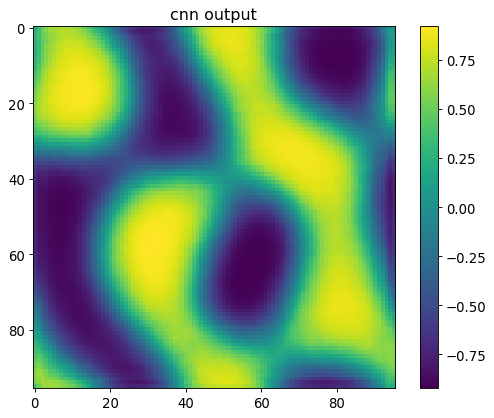

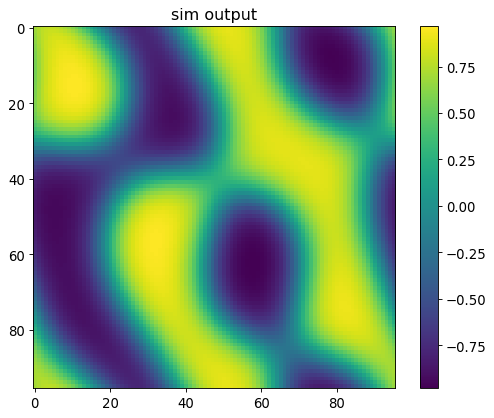

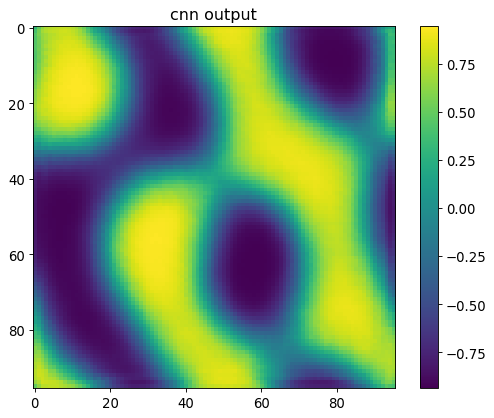

tensor(0.0879, device='cuda:0', dtype=torch.float64)
[tensor(0.1011, device='cuda:0', dtype=torch.float64), tensor(0.1138, device='cuda:0', dtype=torch.float64), tensor(0.0651, device='cuda:0', dtype=torch.float64), tensor(0.0590, device='cuda:0', dtype=torch.float64)]


In [114]:
ix = 25

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[0], "inp")

draw_im(im_y1[0], "sim output")
draw_im(im_y2[0], "cnn output")

draw_im(im_y1[1], "sim output")
draw_im(im_y2[1], "cnn output")

draw_im(im_y1[2], "sim output")
draw_im(im_y2[2], "cnn output")

draw_im(im_y1[3], "sim output")
draw_im(im_y2[3], "cnn output")

print(rmse_loss(y1, y2).data)
print([rmse_loss(y1[0][c], y2[0][c]).data for c in range(4)])

In [115]:
%%time
x_val, y_val = data_generator(nsamples=32, 
                              dim_x=dim_x, 
                                init_steps=3000, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)

No. of validation steps: 4
CPU times: user 1.01 s, sys: 7.64 ms, total: 1.02 s
Wall time: 1.01 s


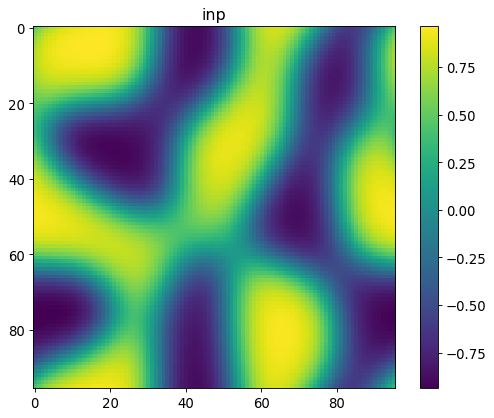

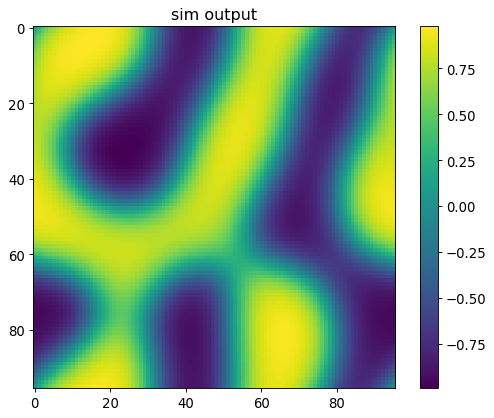

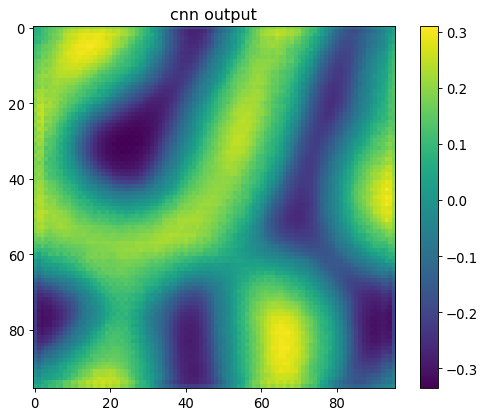

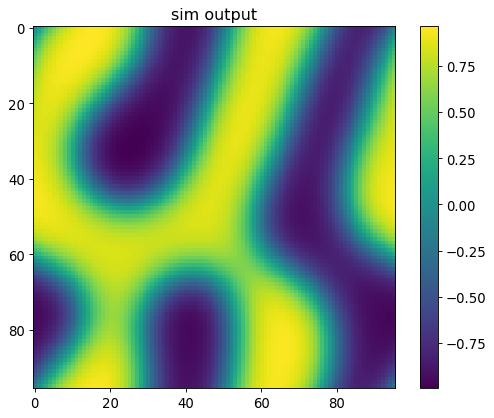

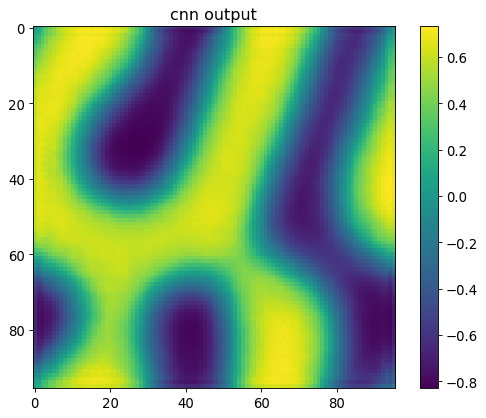

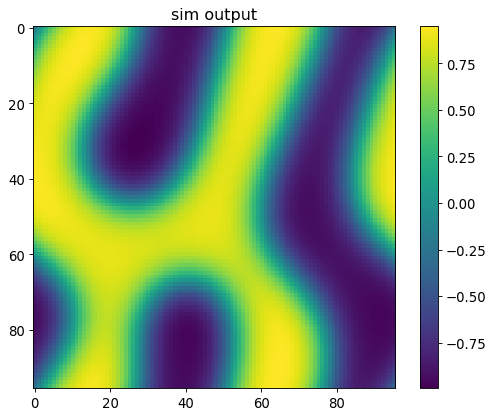

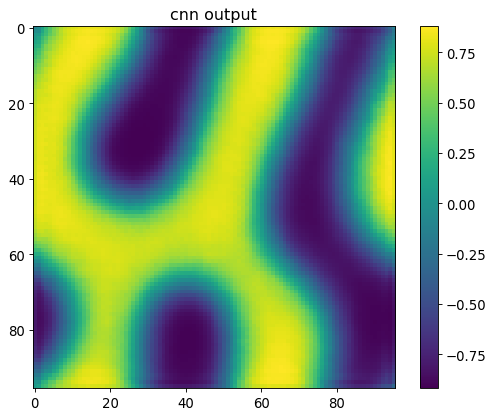

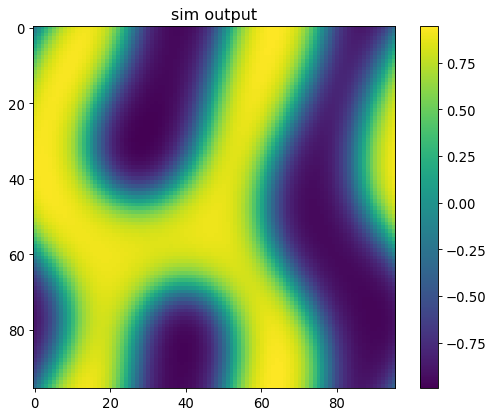

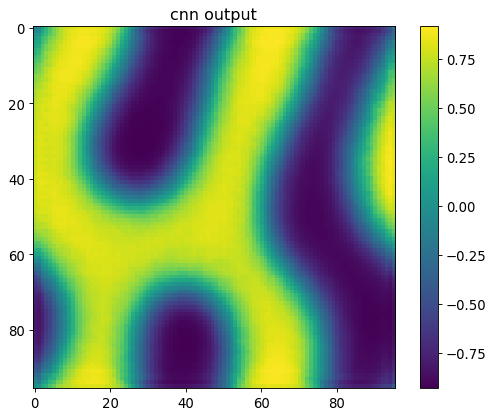

tensor(0.2668, device='cuda:0', dtype=torch.float64)
[tensor(0.4914, device='cuda:0', dtype=torch.float64), tensor(0.1767, device='cuda:0', dtype=torch.float64), tensor(0.0776, device='cuda:0', dtype=torch.float64), tensor(0.0771, device='cuda:0', dtype=torch.float64)]


In [113]:
ix = 10

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[0], "inp")

draw_im(im_y1[0], "sim output")
draw_im(im_y2[0], "cnn output")

draw_im(im_y1[1], "sim output")
draw_im(im_y2[1], "cnn output")

draw_im(im_y1[2], "sim output")
draw_im(im_y2[2], "cnn output")

draw_im(im_y1[3], "sim output")
draw_im(im_y2[3], "cnn output")

print(rmse_loss(y1, y2).data)
print([rmse_loss(y1[0][c], y2[0][c]).data for c in range(4)])

In [120]:
%%time
x_val, y_val = data_generator(nsamples=8, 
                              dim_x=256, 
                                init_steps=1000, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)

No. of validation steps: 1
CPU times: user 1.13 s, sys: 296 ms, total: 1.42 s
Wall time: 1.41 s


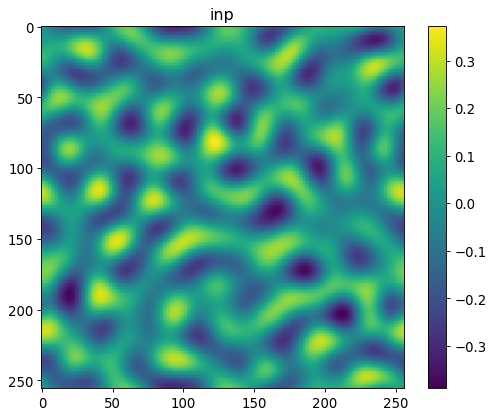

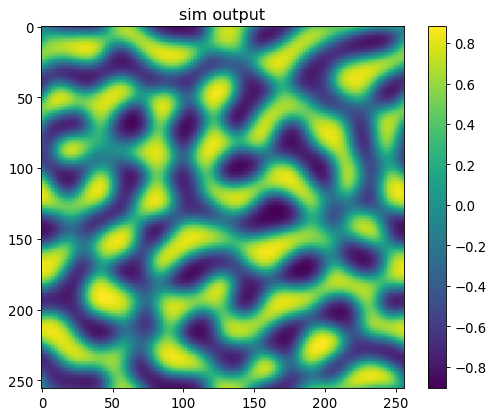

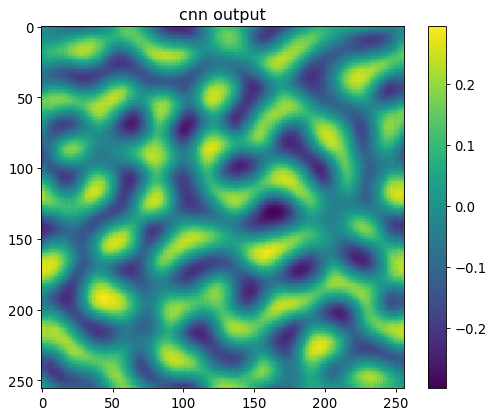

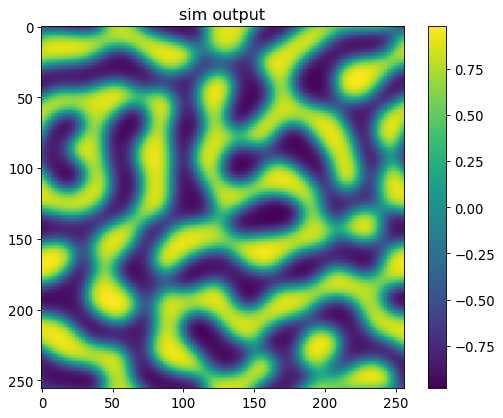

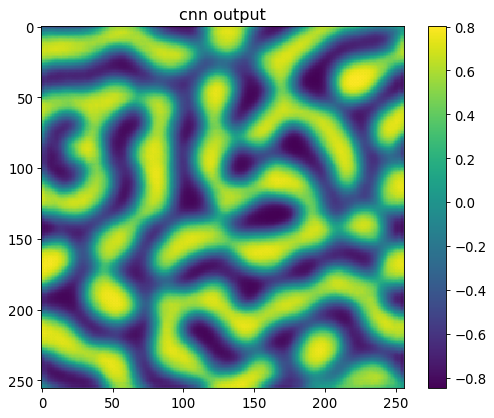

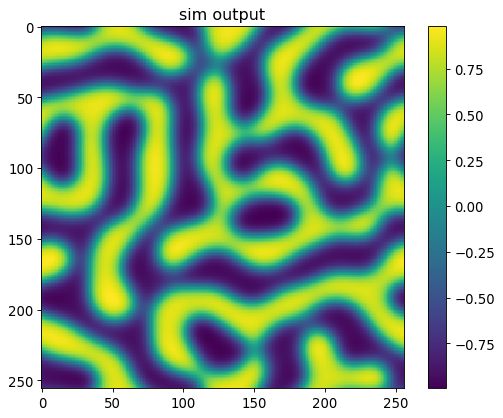

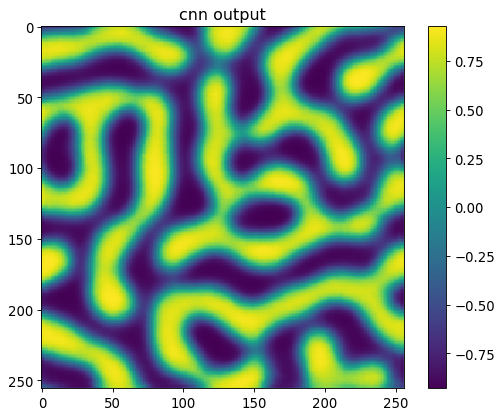

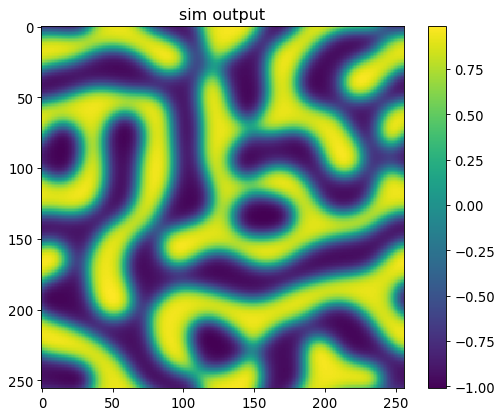

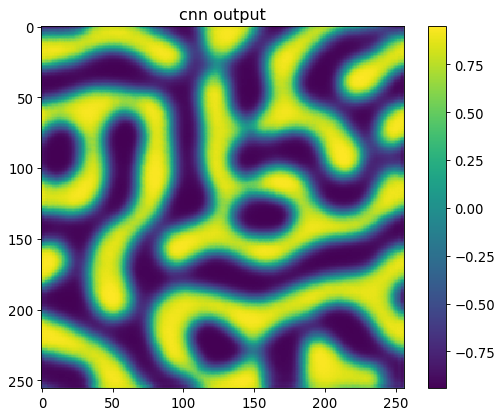

tensor(0.2094, device='cuda:0', dtype=torch.float64)
[tensor(0.3768, device='cuda:0', dtype=torch.float64), tensor(0.1443, device='cuda:0', dtype=torch.float64), tensor(0.0774, device='cuda:0', dtype=torch.float64), tensor(0.0816, device='cuda:0', dtype=torch.float64)]


In [121]:
ix = 5

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[0], "inp")

draw_im(im_y1[0], "sim output")
draw_im(im_y2[0], "cnn output")

draw_im(im_y1[1], "sim output")
draw_im(im_y2[1], "cnn output")

draw_im(im_y1[2], "sim output")
draw_im(im_y2[2], "cnn output")

draw_im(im_y1[3], "sim output")
draw_im(im_y2[3], "cnn output")

print(rmse_loss(y1, y2).data)
print([rmse_loss(y1[0][c], y2[0][c]).data for c in range(4)])

No. of validation steps: 1


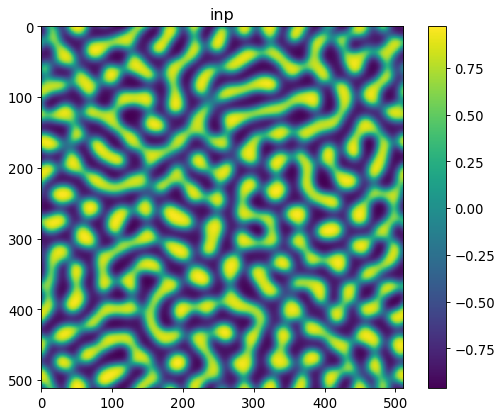

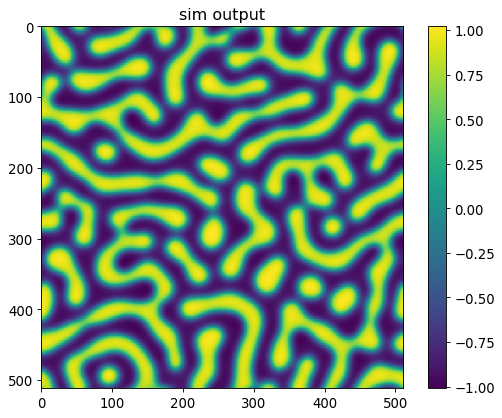

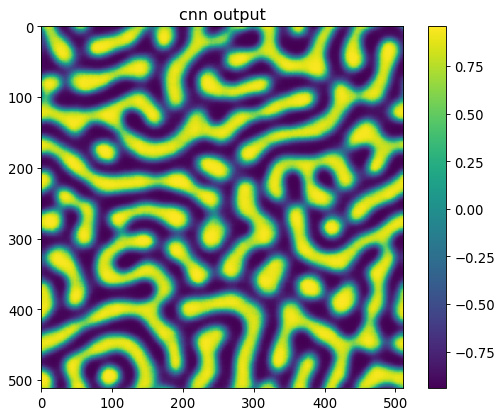

tensor(0.2512, device='cuda:0', dtype=torch.float64)
[tensor(0.4598, device='cuda:0', dtype=torch.float64), tensor(0.1591, device='cuda:0', dtype=torch.float64), tensor(0.0860, device='cuda:0', dtype=torch.float64), tensor(0.0906, device='cuda:0', dtype=torch.float64)]


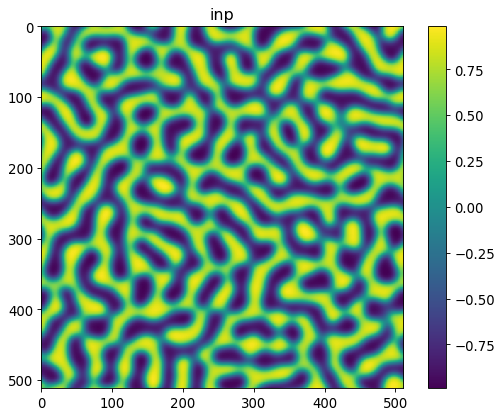

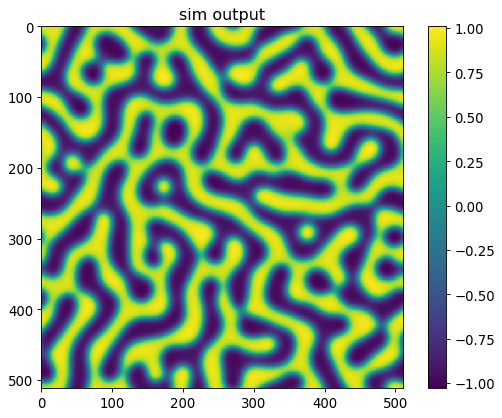

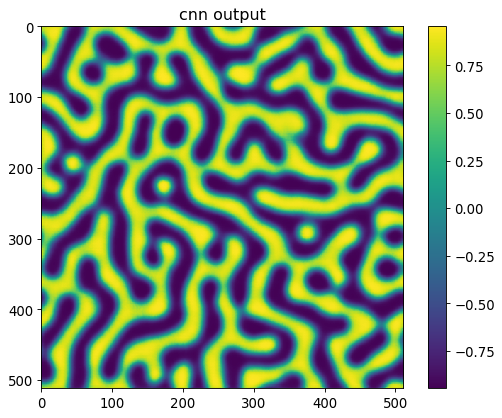

tensor(0.2560, device='cuda:0', dtype=torch.float64)
[tensor(0.4755, device='cuda:0', dtype=torch.float64), tensor(0.1522, device='cuda:0', dtype=torch.float64), tensor(0.0765, device='cuda:0', dtype=torch.float64), tensor(0.0834, device='cuda:0', dtype=torch.float64)]
CPU times: user 4.85 s, sys: 7.07 s, total: 11.9 s
Wall time: 4.04 s


In [138]:
%%time
x_val, y_val = data_generator(nsamples=2, 
                              dim_x=512, 
                              init_steps=3000, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =174753,
                                device = device)

val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)


ix = 0

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[0], "inp")

# draw_im(im_y1[0], "sim output")
# draw_im(im_y2[0], "cnn output")

# draw_im(im_y1[1], "sim output")
# draw_im(im_y2[1], "cnn output")

# draw_im(im_y1[2], "sim output")
# draw_im(im_y2[2], "cnn output")

draw_im(im_y1[3], "sim output")
draw_im(im_y2[3], "cnn output")

print(rmse_loss(y1, y2).data)
print([rmse_loss(y1[0][c], y2[0][c]).data for c in range(4)])

ix = 1

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1[0], "inp")

# draw_im(im_y1[0], "sim output")
# draw_im(im_y2[0], "cnn output")

# draw_im(im_y1[1], "sim output")
# draw_im(im_y2[1], "cnn output")

# draw_im(im_y1[2], "sim output")
# draw_im(im_y2[2], "cnn output")

draw_im(im_y1[3], "sim output")
draw_im(im_y2[3], "cnn output")

print(rmse_loss(y1, y2).data)
print([rmse_loss(y1[0][c], y2[0][c]).data for c in range(4)])